# 特徴量エンジニアリング

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'

In [2]:
DATAPATH = "../../../data/"

In [3]:
with open(DATAPATH + "DBLP/keywords.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2512, 'radiometry')

In [4]:
word_dict = {}
for num, kw in enumerate(keywords):
    word_dict[kw] = num

In [5]:
N = len(keywords)
START_YEAR = 2000
END_YEAR   = 2015
YEAR_STD   = END_YEAR - START_YEAR 

In [6]:
pathes = np.load(DATAPATH+"DBLP/pathes.npy")
pathes.shape

(2512, 2512, 21)

In [7]:
STD = 10
pathes_s1, pathes_s2, pathes_s3 = pathes[:,:,:-STD], pathes[:,:,:-STD-1], pathes[:,:,:-STD-2]
pathes_s1.shape, pathes_s2.shape, pathes_s3.shape

((2512, 2512, 11), (2512, 2512, 10), (2512, 2512, 9))

## 隣接行列の作成

In [8]:
pathes_sum1 = np.sum(pathes_s1, axis=2)
pathes_sum2 = np.sum(pathes_s2, axis=2)
pathes_sum3 = np.sum(pathes_s3, axis=2)
# 厳密な隣接行列ではない
adj = np.where(pathes_sum1 <= 0, 0, 1)
adj_ex2, adj_ex3 = np.where(pathes_sum2 <= 0, 0, 1), np.where(pathes_sum3 <= 0, 0, 1)
adj.shape

(2512, 2512)

## 次数の計算

In [9]:
degs1 = np.sum(adj, axis=0)
degs2 = np.sum(adj, axis=1)
degs = degs1 + degs2
degs.shape

(2512,)

In [10]:
degs1 = np.tile( degs, (N, 1))
degs2 = degs1.T
degs1.shape, degs2.shape

((2512, 2512), (2512, 2512))

In [11]:
keyword_dict = {}
for deg, kw in zip(degs, keywords):
    keyword_dict[kw] = deg

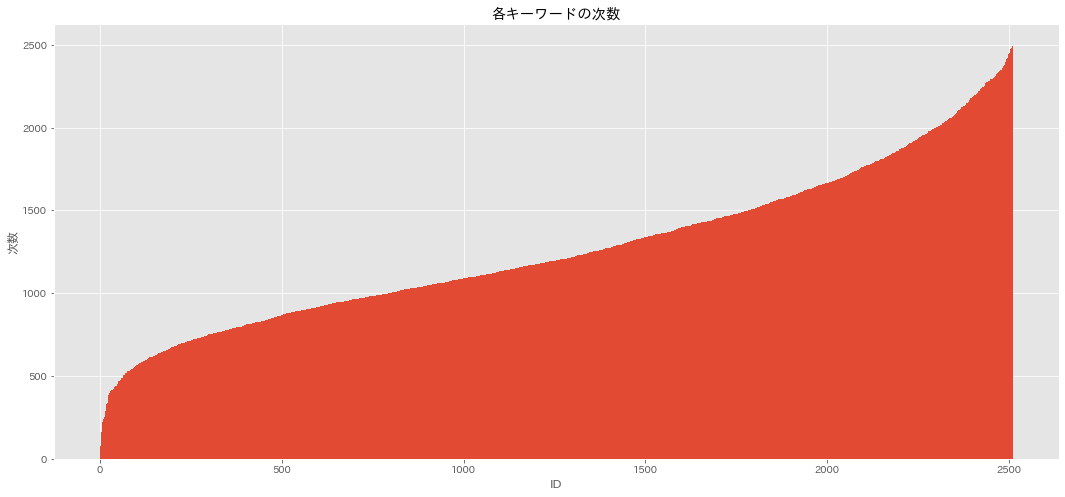

In [12]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("各キーワードの次数")
ax.set_xlabel("ID")
ax.set_ylabel("次数")

# Axesに棒グラフを追加
ax.bar(range(N), sorted(degs), width=1)

plt.show()

## 論文数

In [13]:
papers1 = np.sum(pathes_sum1, axis=0)
papers2 = np.sum(pathes_sum1, axis=1)
papers = papers1 + papers2
papers.shape

(2512,)

In [14]:
papers1 = np.tile( papers, (N, 1))
papers2 = papers1.T
papers1.shape, papers2.shape

((2512, 2512), (2512, 2512))

In [15]:
papers_dict = {}
for paper, kw in zip(papers, keywords):
    keyword_dict[kw] = paper

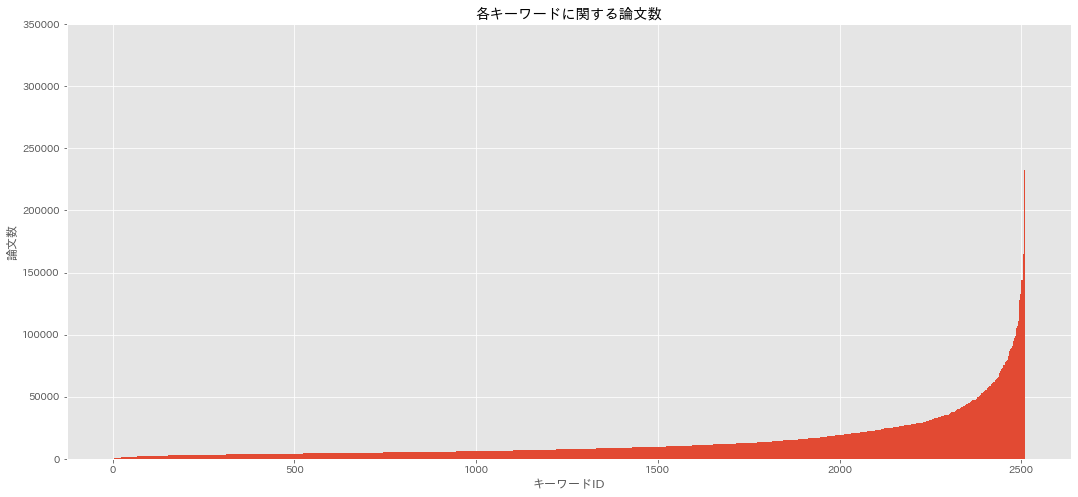

In [16]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("各キーワードに関する論文数")
ax.set_xlabel("キーワードID")
ax.set_ylabel("論文数")

# Axesに棒グラフを追加
ax.bar(range(N), sorted(papers), width=1)

plt.show()

## 距離n(=2,3,4)のノード数
隣接行列の冪乗(n乗)は、距離nである各点から他の点までのルート数を表すことを利用する

In [17]:
adj = adj + adj.T
print("グラフの密度は、{}".format(round(np.sum(adj) / len(adj) / len(adj), 3)))

グラフの密度は、0.505


かなり密なグラフ

In [18]:
import dask.array as da

In [19]:
adj

array([[0, 1, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [20]:
%%time
def dadot(arr, p):
    darr = da.from_array(arr, chunks=(1000,1000))
    dadot = da.dot(darr, darr)
    return dadot.compute()

dadot(adj, 2)

CPU times: user 1min 13s, sys: 920 ms, total: 1min 14s
Wall time: 12 s


array([[ 789,  757,  529, ...,  389,  489,  259],
       [ 757, 2264,  766, ...,  490,  833,  388],
       [ 529,  766,  794, ...,  379,  446,  221],
       ...,
       [ 389,  490,  379, ...,  505,  337,  158],
       [ 489,  833,  446, ...,  337,  876,  259],
       [ 259,  388,  221, ...,  158,  259,  420]])

In [21]:
%%time
np.linalg.matrix_power(adj, 2)

CPU times: user 1min 15s, sys: 152 ms, total: 1min 15s
Wall time: 1min 15s


array([[ 789,  757,  529, ...,  389,  489,  259],
       [ 757, 2264,  766, ...,  490,  833,  388],
       [ 529,  766,  794, ...,  379,  446,  221],
       ...,
       [ 389,  490,  379, ...,  505,  337,  158],
       [ 489,  833,  446, ...,  337,  876,  259],
       [ 259,  388,  221, ...,  158,  259,  420]])

In [22]:

%%time
adj2 = dadot(adj, 2)
adj3 = dadot(adj, 3)
adj4 = dadot(adj, 4)

CPU times: user 3min 42s, sys: 2.26 s, total: 3min 44s
Wall time: 35.2 s


In [23]:
adj_ex2 = adj_ex2 + adj_ex2.T
adj2_ex1 = dadot(adj_ex2, 2)
adj3_ex1 = dadot(adj_ex2, 3)
adj4_ex1 = dadot(adj_ex2, 4)

In [24]:
adj_ex3 = adj_ex3 + adj_ex3.T
adj2_ex2 = dadot(adj_ex3, 2)
adj3_ex2 = dadot(adj_ex3, 3)
adj4_ex2 = dadot(adj_ex3, 4)

## 距離
各ノード間の距離を求める

In [25]:
import numpy as np
from scipy.sparse.csgraph import shortest_path, floyd_warshall, dijkstra, bellman_ford, johnson
from scipy.sparse import csr_matrix

In [26]:
%%time
distances = shortest_path(adj)
distances.shape

CPU times: user 17.1 s, sys: 288 ms, total: 17.4 s
Wall time: 17.3 s


(2512, 2512)

In [27]:
pathes_sum = pathes_sum1 + pathes_sum1.T
distances2 = shortest_path(np.array(pathes_sum))
distances2.shape

(2512, 2512)

In [28]:
degs = degs.reshape([1,-1])
diss = degs.T.dot(degs)
diss.shape

(2512, 2512)

In [29]:
diss_sqrt = np.sqrt(diss)
diss_sqrt.shape

(2512, 2512)

In [30]:
distances3 = distances * diss
distances4 = distances * diss_sqrt

## コサイン類似度

In [31]:
cosine_sim = adj2 / diss_sqrt
cosine_sim.shape

(2512, 2512)

# 標準化

In [33]:
adj2 = adj2 / np.max(adj2)
adj3 = adj3 / np.max(adj3)
adj4 = adj4 / np.max(adj4)

In [34]:
adj2_ex1 = adj2_ex1 / np.max(adj2_ex1)
adj3_ex1 = adj3_ex1 / np.max(adj3_ex1)
adj4_ex1 = adj4_ex1 / np.max(adj4_ex1)

In [35]:
adj2_ex2 = adj2_ex2 / np.max(adj2_ex2)
adj3_ex2 = adj3_ex2 / np.max(adj3_ex2)
adj4_ex2 = adj4_ex2 / np.max(adj4_ex2)

In [36]:
distances = distances / np.max(distances)
distances2 = distances2 / np.max(distances2)
distances3 = distances3 / np.max(distances3)
distances4 = distances4 / np.max(distances4)

# 特徴量

In [39]:
data = np.stack([
    degs1, degs2, papers1, papers2, cosine_sim, adj2, adj2_ex1, adj2_ex2, adj3, adj3_ex1, adj3_ex2, adj4, adj4_ex1, adj4_ex2, distances, distances2, distances3, distances4
], 2)
data.shape

(2512, 2512, 18)

In [41]:
np.save(DATAPATH + "DBLP/train_x.npy", data)

## 目的変数
時を経つごとに、論文数が減っている

In [55]:
preds = pathes[:,:,-STD:-STD+5]

preds.shape, preds_s.shape

((2512, 2512, 5), (2512, 2512, 5))

In [51]:
preds = np.sum(preds, axis=2)
preds.shape

(2512, 2512)

In [52]:
p = preds.reshape(-1)

In [54]:
np.count_nonzero(p > 0) / N / N

(0.1803003227818573, 0.0394849943202564)

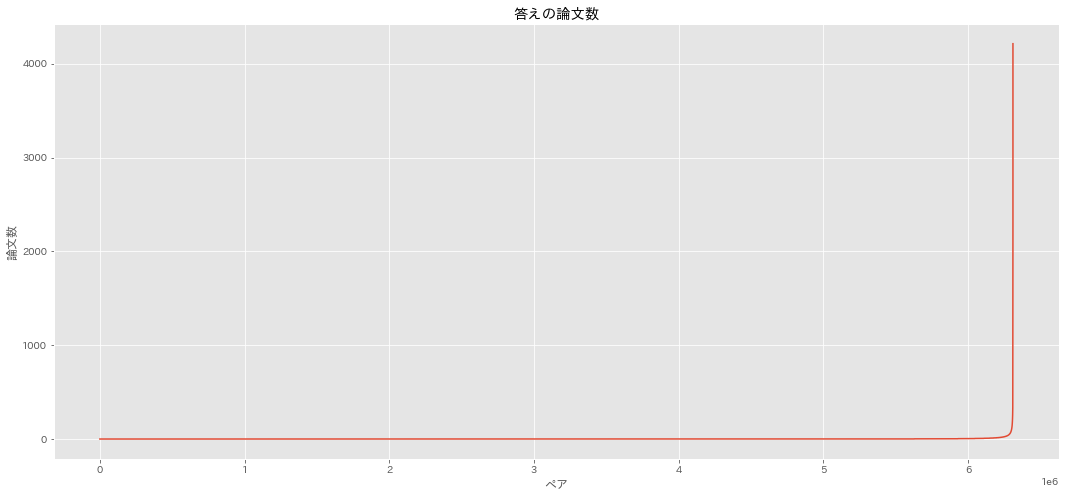

In [59]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("答えの論文数")
ax.set_xlabel("ペア")
ax.set_ylabel("論文数")

# Axesに棒グラフを追加
ax.plot(range(N*N), sorted(p))

plt.show()

In [60]:
np.save(DATAPATH + "DBLP/train_y.npy", preds)